In [1]:
# imports
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
plt.style.use('seaborn')

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
affluent = pd.read_hdf('averaged_daily.h5', key='affluent')
comfortable = pd.read_hdf('averaged_daily.h5', key='comfortable')
adversity = pd.read_hdf('averaged_daily.h5', key='adversity')
dtemp = pd.read_hdf('temp.h5', 'data')
dailytemp = dtemp.resample('1D').mean()

In [47]:
df = pd.DataFrame(affluent,columns=['affluent'])
df['comfortable'] = comfortable
df['adversity'] = adversity
df['temperature'] = dailytemp
df['time_idx'] = (df.index.to_series()-df.index.to_series().min()).dt.days
df['group_id'] = np.ones(len(df)).astype(int)
df.temperature = df.temperature.fillna((9.522222+16.957143)/2)
df

,affluent,comfortable,adversity,temperature,time_idx,group_id
2011-11-24,0.217208,0.136795,0.178417,10.641667,0,1
2011-11-25,0.162797,0.178794,0.140479,11.083333,1,1
2011-11-26,0.160906,0.172090,0.125604,10.350000,2,1
2011-11-27,0.174906,0.169097,0.119583,11.275000,3,1
2011-11-28,0.177285,0.159982,0.246620,7.029167,4,1
...,...,...,...,...,...,...
2014-02-24,0.229024,0.193006,0.172777,10.916667,823,1
2014-02-25,0.229198,0.190123,0.170753,9.158333,824,1
2014-02-26,0.230026,0.189837,0.173338,7.833333,825,1
2014-02-27,0.232494,0.191105,0.169270,7.862500,826,1


In [60]:
df[:365]

,affluent,comfortable,adversity,temperature,time_idx,group_id
2011-11-24,0.217208,0.136795,0.178417,10.641667,0,1
2011-11-25,0.162797,0.178794,0.140479,11.083333,1,1
2011-11-26,0.160906,0.172090,0.125604,10.350000,2,1
2011-11-27,0.174906,0.169097,0.119583,11.275000,3,1
2011-11-28,0.177285,0.159982,0.246620,7.029167,4,1
...,...,...,...,...,...,...
2012-11-18,0.270205,0.222326,0.202779,5.841667,360,1
2012-11-19,0.256784,0.204529,0.190437,8.716667,361,1
2012-11-20,0.249320,0.206781,0.185097,12.441667,362,1
2012-11-21,0.252394,0.207297,0.187051,9.533333,363,1


In [73]:
# define dataset
max_encoder_length = 32
max_prediction_length = 32

training = TimeSeriesDataSet(df[:365],time_idx='time_idx', target='affluent', group_ids=['group_id'],
                             time_varying_unknown_reals=['affluent'], 
                             time_varying_known_reals=['time_idx', 'temperature', 'comfortable', 'adversity'],
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length)

# create validation and training dataset
validation = TimeSeriesDataSet.from_dataset(training, df, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12,
                                          shuffle=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=12)

# define trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=-1,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [74]:
training.index

,time_first,time_last,time_diff_to_next,index_start,time,count,group_id,index_end,sequence_length
2011-11-24,0,364,1,0,0,365,0,63,64
2011-11-25,0,364,1,1,1,365,0,64,64
2011-11-26,0,364,1,2,2,365,0,65,64
2011-11-27,0,364,1,3,3,365,0,66,64
2011-11-28,0,364,1,4,4,365,0,67,64
...,...,...,...,...,...,...,...,...,...
2012-09-16,0,364,1,297,297,365,0,360,64
2012-09-17,0,364,1,298,298,365,0,361,64
2012-09-18,0,364,1,299,299,365,0,362,64
2012-09-19,0,364,1,300,300,365,0,363,64


In [75]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.01802688278257847

In [76]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=-1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 19.6k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

suggested learning rate: 5.888436553555889e-06


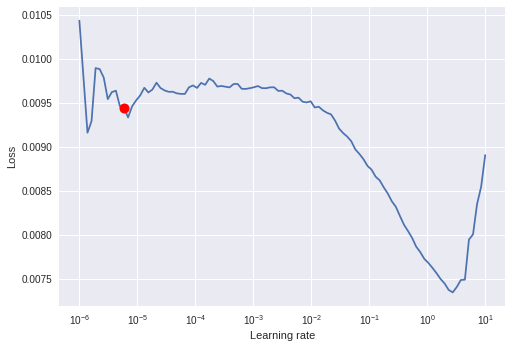

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


In [77]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [83]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=60,
    gpus=-1,
    weights_summary="top",
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=1e-1,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss= QuantileLoss(),
    log_interval=10,
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 19.6k


In [84]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

1

In [85]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0394)

In [86]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

0.01802688278257847

In [ ]:
predictions = tft.predict()

In [62]:
x,(y,w )= next(iter(val_dataloader))

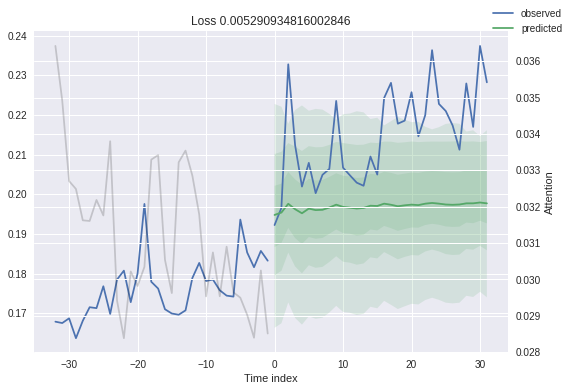

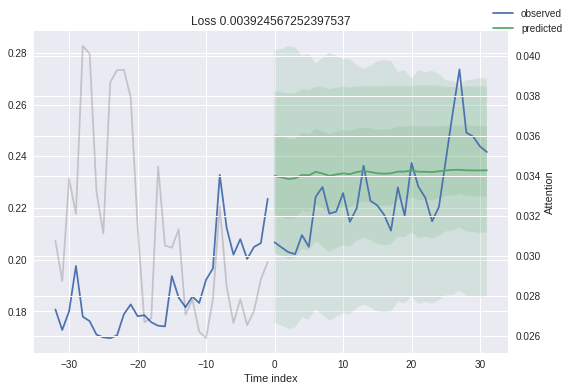

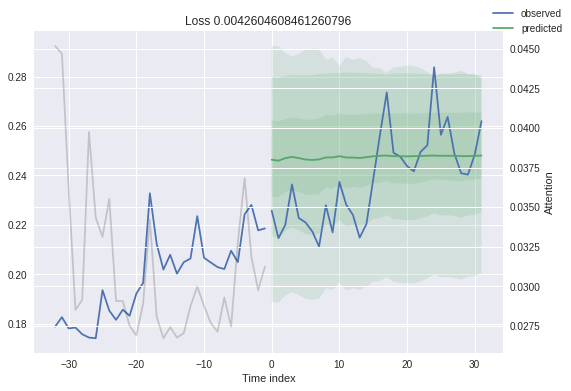

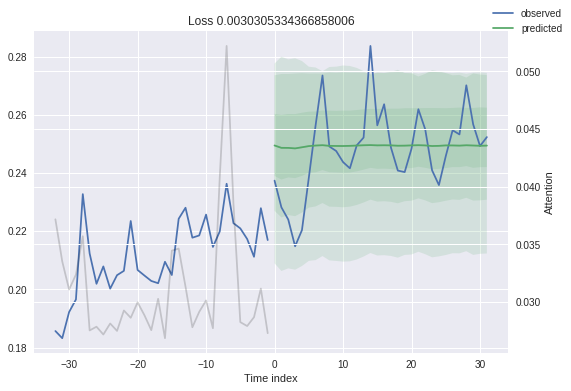

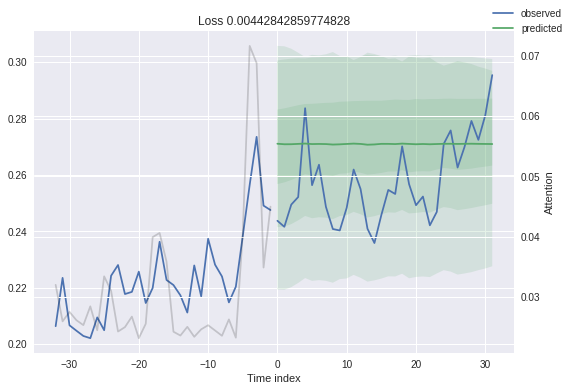

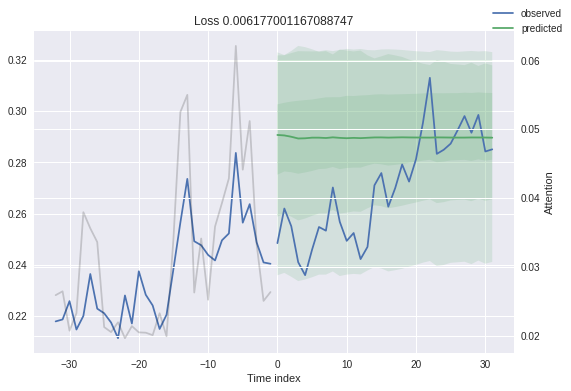

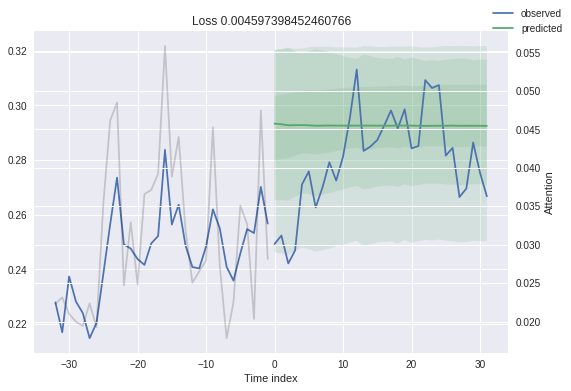

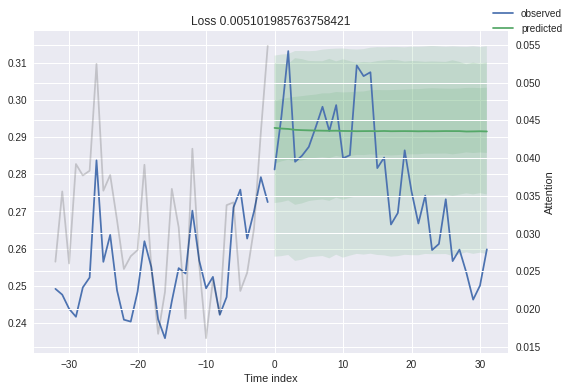

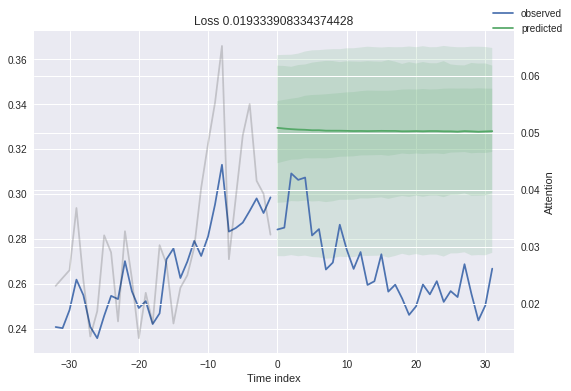

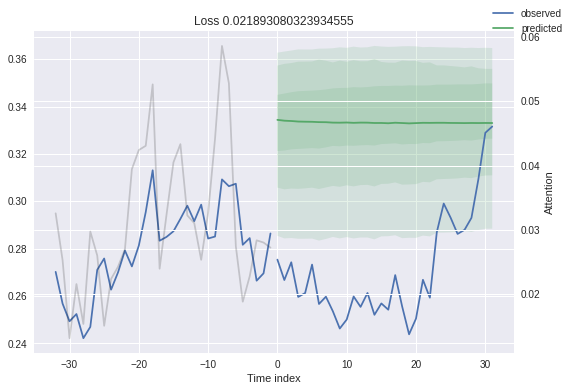

In [89]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x, index = tft.predict(val_dataloader, mode="raw", return_x=True, return_index=True)
for idx in range(100):  # plot 10 examples
    if idx%10!=0:
        continue
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);